In [1]:
# ① tsfresh 라이브러리 설치
!pip install tsfresh

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# # ② 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
# import os
# os.kill(os.getpid(), 9)

In [2]:
# ③ robot_execution_failures 데이터셋 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

/Users/kenny_jung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [13]:
# ④ 추가로 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
%config InlineBackend.figure_format = 'retina'

In [4]:
# ⑤ 데이터셋 가공
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum()*test_size)           # int(21 * 0.3) = 6
    num_false = int((len(y)-y.sum())*test_size) # int((88 - 21)*0.3) = 20

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    # y==False인것과 y==True인것의 인덱스값을 리스트로 변환하여 더해줍니다.
    # y[y==False].head(num_false).index.to_list()는 19~38까지의 값이 리스트로
    # y[y==True].head(num_true).index.to_list()는 1~6까지의 값이 리스트로 
    # id_list는 20~39 + 2~7이 더해진 리스트입니다.

    y_train = y.drop(id_list)                            # y에서 id_list를 drop합니다.  
    y_test = y.iloc[id_list].sort_index()                # 20~39, 2~7이 합쳐진 리스트를 정렬합니다.
    X_train = x[~x['id'].isin(id_list)] # 대괄호 안에 있는 timeseries의 id와 id_list가 일치하는 것만 사용하고 물결표시는 안에 조건이 포함되어 있지 않는것만 사용하는 것입니다.
    X_test = x[x['id'].isin(id_list)]   # timeseries의 id와 id_list가 일치하는 것만 사용해서 timeseries에 적용

    return X_train, y_train, X_test, y_test

In [5]:
# 커스텀한 함수를 적용한 데이터셋이 어떤 차이가 있는지 확인해봅시다.
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)
print(X_train)
print('-'*50)
print(y_train)
print('-'*50)
print(X_test)
print('-'*50)
print(y_test)


      id  time  F_x  F_y  F_z  T_x  T_y  T_z
90     7     0   -3    1   53  -10   -4    0
91     7     1    0   -2   65   -4   -1    0
92     7     2   -1   -1   56   -7   -3    0
93     7     3    0   -2   60   -6    0    0
94     7     4   -1   -1   57   -7   -4    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[930 rows x 8 columns]
--------------------------------------------------
7      True
8      True
9      True
10     True
11     True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 62, dtype: bool
--------------------------------------------------
     id  time  F_x  F_y  F_z  T_x  T_y  T_z
0     1     0   -1   -1   63   -3   -1    0
1     1     1    0    0   62   -3   -1    0
2     1     2   -1   -1   61   -3    0    0
3 

In [6]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y)
print(X_train.shape)
print('-' * 50)
print(y_train.shape)
print('-' * 50)
print(X_test.shape)
print('-' * 50)
print(y_test.shape)

(930, 8)
--------------------------------------------------
(62,)
--------------------------------------------------
(390, 8)
--------------------------------------------------
(26,)


In [7]:
# ⑥ 특징추출하기
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

settings = MinimalFCParameters() # 계산 효율을 위해 minimal 셋팅
minimal_features_train = extract_features(
                                X_train,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )

minimal_features_test = extract_features(
                                X_test,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings # minimal 적용
                           )


Feature Extraction: 100%|██████████| 23/23 [00:01<00:00, 15.58it/s]


In [8]:
# ⑦ 추출된 특징 확인
minimal_features_train

,F_x__sum_values,F_x__median,F_x__mean,F_x__length,F_x__standard_deviation,F_x__variance,F_x__root_mean_square,F_x__maximum,F_x__absolute_maximum,F_x__minimum,...,T_z__sum_values,T_z__median,T_z__mean,T_z__length,T_z__standard_deviation,T_z__variance,T_z__root_mean_square,T_z__maximum,T_z__absolute_maximum,T_z__minimum
7,-13.0,-1.0,-0.866667,15.0,0.805536,0.648889,1.183216,0.0,3.0,-3.0,...,-1.0,0.0,-0.066667,15.0,0.442217,0.195556,0.447214,1.0,1.0,-1.0
8,-10.0,-1.0,-0.666667,15.0,1.135292,1.288889,1.316561,2.0,2.0,-2.0,...,0.0,0.0,0.000000,15.0,1.032796,1.066667,1.032796,3.0,3.0,-1.0
9,-10.0,-1.0,-0.666667,15.0,1.074968,1.155556,1.264911,2.0,3.0,-3.0,...,3.0,0.0,0.200000,15.0,1.045626,1.093333,1.064581,3.0,3.0,-1.0
10,-14.0,-1.0,-0.933333,15.0,0.249444,0.062222,0.966092,0.0,1.0,-1.0,...,0.0,0.0,0.000000,15.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
11,-13.0,-1.0,-0.866667,15.0,0.956847,0.915556,1.290994,1.0,3.0,-3.0,...,-3.0,0.0,-0.200000,15.0,0.400000,0.160000,0.447214,0.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-1073.0,-98.0,-71.533333,15.0,36.585729,1338.515556,80.346334,-25.0,110.0,-110.0,...,-232.0,-21.0,-15.466667,15.0,9.659998,93.315556,18.235497,0.0,28.0,-28.0
85,143.0,8.0,9.533333,15.0,4.616877,21.315556,10.592450,19.0,19.0,4.0,...,-52.0,-2.0,-3.466667,15.0,2.156128,4.648889,4.082483,0.0,7.0,-7.0
86,961.0,52.0,64.066667,15.0,38.235179,1461.928889,74.608757,148.0,148.0,21.0,...,-81.0,-8.0,-5.400000,15.0,5.462600,29.840000,7.681146,8.0,10.0,-10.0
87,4509.0,338.0,300.600000,15.0,57.753268,3335.440000,306.097697,342.0,342.0,171.0,...,475.0,35.0,31.666667,15.0,9.903983,98.088889,33.179311,44.0,44.0,13.0


In [9]:
minimal_features_train.columns

Index(['F_x__sum_values', 'F_x__median', 'F_x__mean', 'F_x__length',
       'F_x__standard_deviation', 'F_x__variance', 'F_x__root_mean_square',
       'F_x__maximum', 'F_x__absolute_maximum', 'F_x__minimum',
       'F_y__sum_values', 'F_y__median', 'F_y__mean', 'F_y__length',
       'F_y__standard_deviation', 'F_y__variance', 'F_y__root_mean_square',
       'F_y__maximum', 'F_y__absolute_maximum', 'F_y__minimum',
       'F_z__sum_values', 'F_z__median', 'F_z__mean', 'F_z__length',
       'F_z__standard_deviation', 'F_z__variance', 'F_z__root_mean_square',
       'F_z__maximum', 'F_z__absolute_maximum', 'F_z__minimum',
       'T_x__sum_values', 'T_x__median', 'T_x__mean', 'T_x__length',
       'T_x__standard_deviation', 'T_x__variance', 'T_x__root_mean_square',
       'T_x__maximum', 'T_x__absolute_maximum', 'T_x__minimum',
       'T_y__sum_values', 'T_y__median', 'T_y__mean', 'T_y__length',
       'T_y__standard_deviation', 'T_y__variance', 'T_y__root_mean_square',
       'T_y__maximu

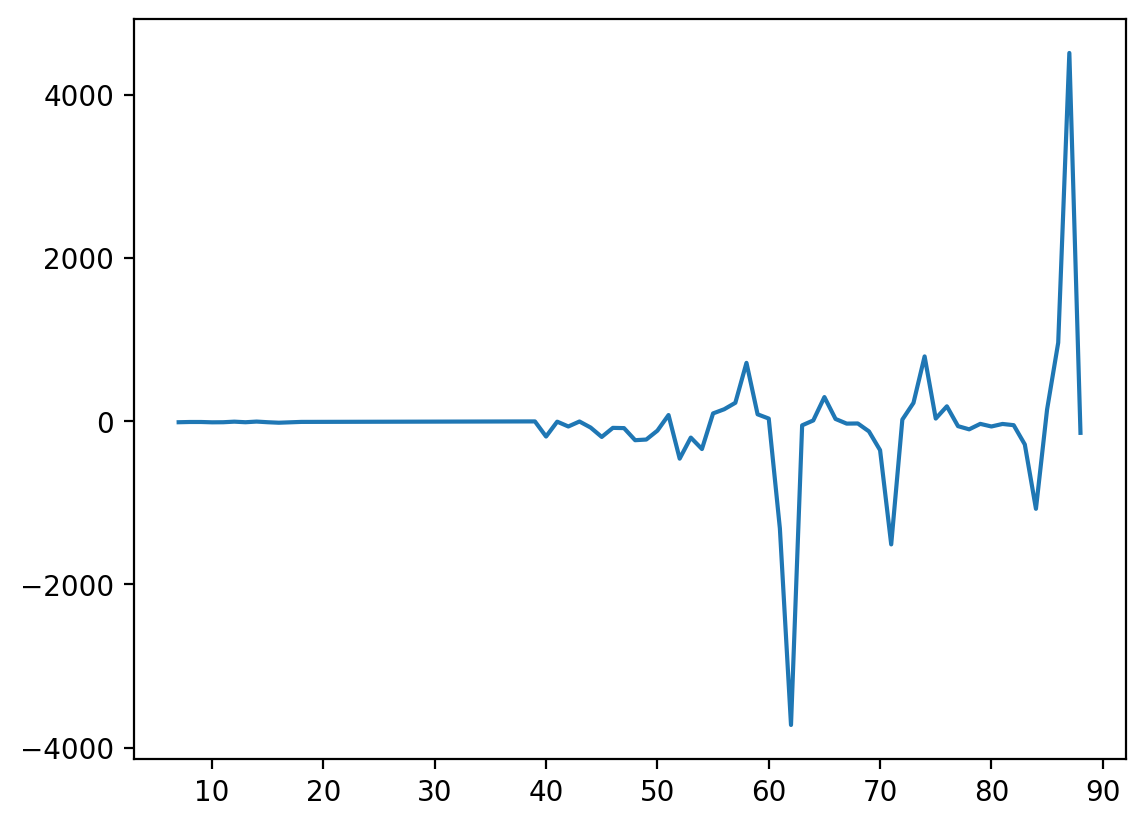

In [14]:
# ⑧ 추출된 특징 시각화하기
plt.plot(minimal_features_train['F_x__sum_values'])
plt.show()

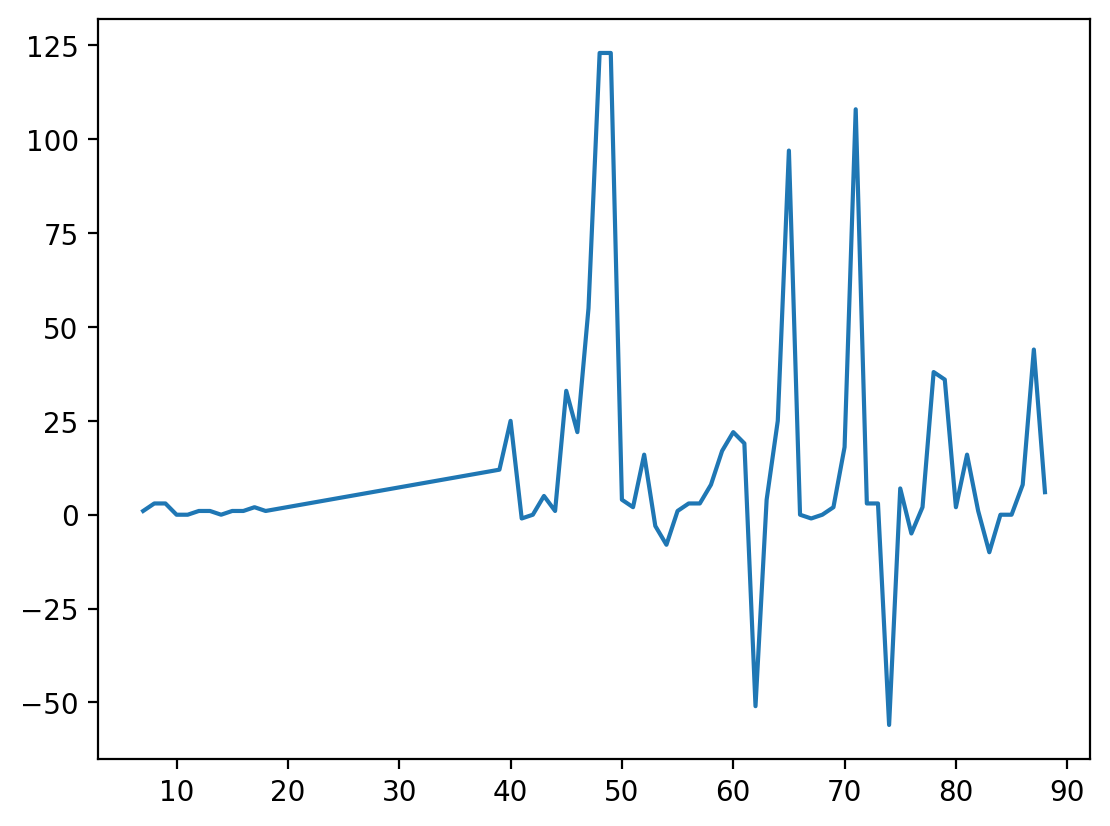

In [15]:
plt.plot(minimal_features_train['T_z__maximum'])
plt.show()


In [12]:
# ⑨ Logistic Regression 사용하기
logistic = LogisticRegression() 
logistic.fit(minimal_features_train, y_train)

LogisticRegression()

In [16]:
# ⑪ 분류 성능 평가 지표 확인하기
# y는 True, False는 Target으로도 표현할 수 있습니다. 
classification_report(y_test, logistic.predict(minimal_features_test), target_names=['true', 'false'], output_dict=True) # y_test 내부에 있는 true, false와 일치하는 이름을 표시합니다.

{'true': {'precision': 1.0,
  'recall': 0.6,
  'f1-score': 0.7499999999999999,
  'support': 20.0},
 'false': {'precision': 0.42857142857142855,
  'recall': 1.0,
  'f1-score': 0.6,
  'support': 6.0},
 'accuracy': 0.6923076923076923,
 'macro avg': {'precision': 0.7142857142857143,
  'recall': 0.8,
  'f1-score': 0.6749999999999999,
  'support': 26.0},
 'weighted avg': {'precision': 0.868131868131868,
  'recall': 0.6923076923076923,
  'f1-score': 0.7153846153846153,
  'support': 26.0}}